# 数据可视化

In [1]:
%matplotlib inline
import re
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

读取短评数据，用数据创建DataFrame，方便后续可视化。

In [2]:
# 读取文件短评内容
with open('clean_data.csv', 'r') as f:
    comment_data = f.read()
comment_data = comment_data.split('\n') # 以换行符分割短评

# 不同信息添加到相应列表
film_name = [] # 电影名称
user_link = [] # 用户链接
user_name = [] # 用户名称
user_score = [] # 用户评分
comment_time = [] # 评论时间
comment = [] # 短评
follower = [] # 赞同人数
# 将每条短评信息相关字段添加到相应列表
for item in comment_data:
    s = re.search(r'(\w+,)(https://www.douban.com/people/.+/,)(.*,)(\d,)(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},)(.+)(,\d+)', item)
    if s:
        film_name.append(s.group(1)[:-1])
        user_link.append(s.group(2)[:-1])
        user_name.append(s.group(3)[:-1])
        user_score.append(s.group(4)[:-1])
        comment_time.append(s.group(5)[:-1])
        comment.append(s.group(6))
        follower.append(s.group(7)[1:])
        
# 创建DataFrame
comments = pd.DataFrame({'film_name':film_name,
                        'user_link':user_link,
                        'user_name':user_name,
                        'user_score':user_score,
                        'comment_time':comment_time,
                        'comment':comment,
                        'follower':follower})
comments = comments.drop_duplicates() # 去重

# 数据类型转换
comments['user_score'] = pd.to_numeric(comments['user_score'], errors='coerce') # 将用户评分转换为数值类型
comments['follower'] = pd.to_numeric(comments['follower'], errors='coerce') # 将赞同人数转换为数值类型
comments['comment_time'] = pd.to_datetime(comments['comment_time'], errors='coerce') # 将评论时间转换为datetime类型

# 将评论时间设置为索引
comments = comments.set_index('comment_time')

短评数据可视化从四个点进行：
* 总体数据分布情况
* 不同电影数据情况
* 不同时间数据分布情况
* 不同用户分类数据情况

因为抓取的短评数量有限，所以以下可视化及相关分析针对抓取到的数据。

## 总体分布

### 用户评分分布

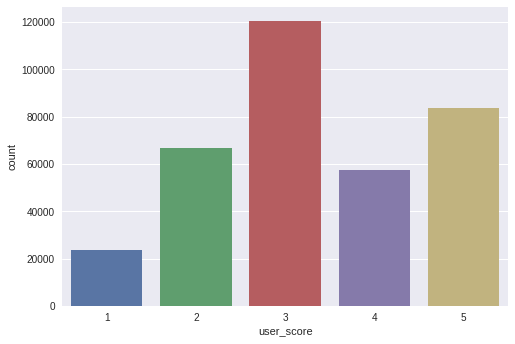

In [12]:
sns.countplot(x='user_score', data=comments)

3分以上为好评，3分为中评，3分以下为差评，从图中可以看出好评是最多，其次为中评，最后为差评

由于爬取短评数据时好评、中评和差评最多只能爬取500条，如果只爬取三种类型的短评用户评分分布差不多，因此总体用户评分分布情况反映最新评论的评分情况，最新评论中好评较多，另外有些电影可能差评不够500条(PS: 毕竟是Top250的电影)，也侧面看出是好电影，差评都没有500条

### 赞同人数分布

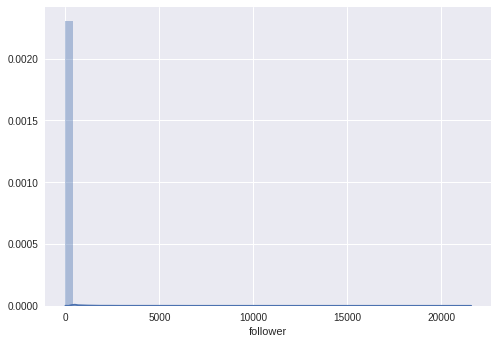

In [16]:
sns.distplot(comments['follower'])

明显赞同人数绝大多数集中在0附近，因此分别将小于100赞同人数和大于100赞同人数的分布

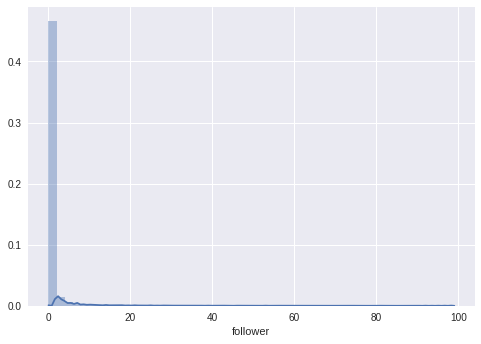

In [24]:
sns.distplot(comments.loc[comments['follower'] < 100, 'follower'])

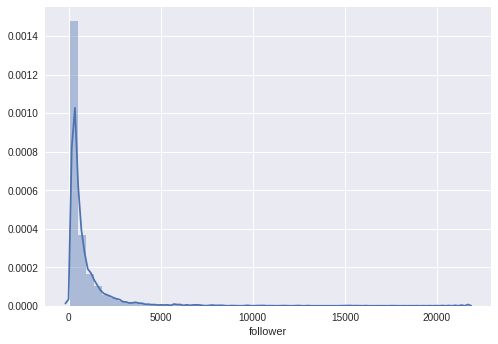

In [23]:
sns.distplot(comments.loc[comments['follower'] > 100, 'follower'])

从上面的图可以看出赞同人数多集中在5以下，同一部电影每个人看的感受不一样，多数短评赞同人数都很少，赞同人数很多的短评原因可能有：短评符合其他人对这部电影的感受，该用户较为活跃有一定的粉丝量，评论时间较早等

### 两者的关系

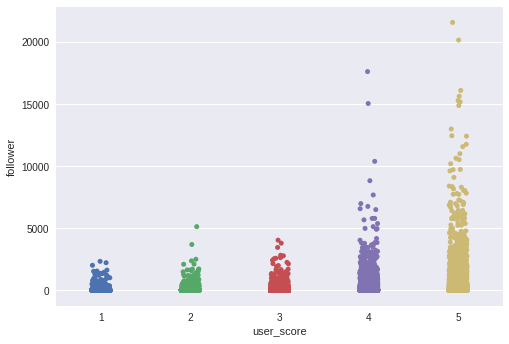

In [26]:
sns.stripplot(x='user_score', y='follower', data=comments, jitter=True)

从两者的关系可以看出用户评分高的短评赞同人数较多，top250电影说明大多数人认为电影很好，那些对电影评价高的短评自然比对电影评价低的短评被人赞同多

## 电影

### 每部电影用户评分均值分布

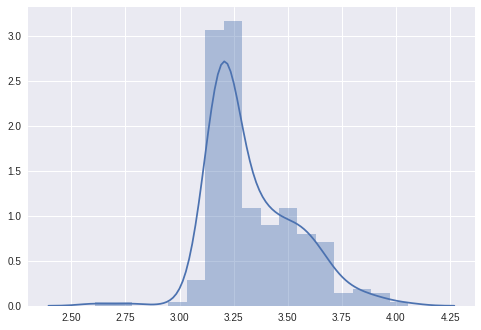

In [30]:
sns.distplot(comments.groupby('film_name')['user_score'].mean().values)

每部电影的用户评分均值绝大部分3-4之间，低于3的很少，这些电影的用户评分都较好

## 时间

### 每年评论量分布

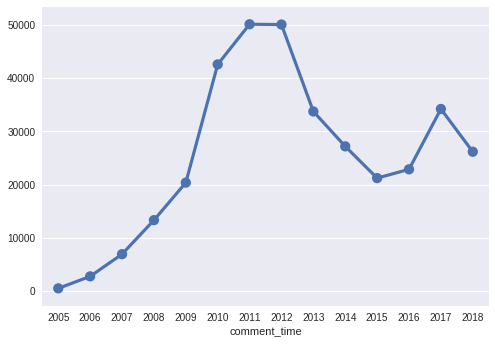

In [36]:
sns.pointplot(comments.resample('AS')['comment'].count().to_period('A').index, comments.resample('AS')['comment'].count().to_period('A').values)

抓取的评论里每年的总评论数从2005年逐年增加，2001和2012短评数最多，后逐渐下降，2017年又上升了，前面几年评论数较少，有可能是因为评论抓取数量有限，前面几年的评论没有抓取多少，也有可能是上豆瓣网的人往后逐年增多，2012年后下降可能是电影上映较多看老电影的人比较少

### 每年用户评分均值分布

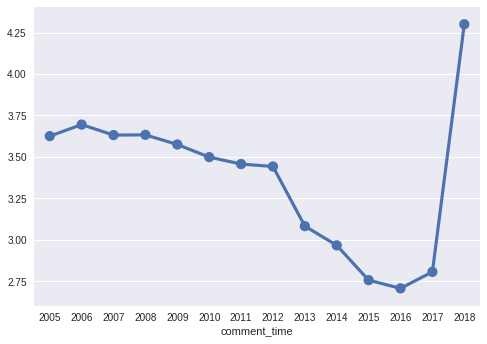

In [37]:
sns.pointplot(comments.resample('AS')['user_score'].mean().to_period('A').index, comments.resample('AS')['user_score'].mean().to_period('A').values)

2012年以前用户评分均值较为稳定，均为3.4以上，2012年后开始下降，2016年最低。

## 用户

In [25]:
# 统计每个用户评论过的电影数量
# 用户链接相同则为同一个用户
user_count = comments.groupby('user_link')['user_link'].count()
comments['actitive'] = 'No'
# 如果用户评论电影数超过一部，分类为活跃用户
comments.loc[comments['user_link'].isin(user_count[user_count != 1].index.values), 'actitive'] = 'Yes'
comments.groupby('actitive')['actitive'].count()

actitive
No      64942
Yes    286964
Name: actitive, dtype: int64

### 单个用户评论电影数量分布

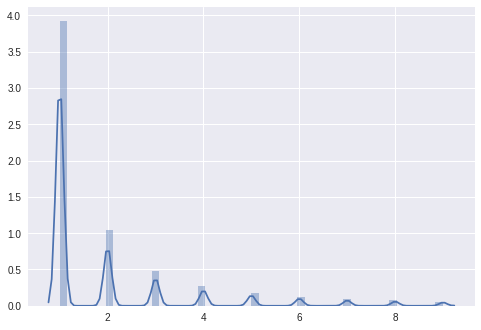

In [15]:
sns.distplot(user_count[user_count < 10].values)

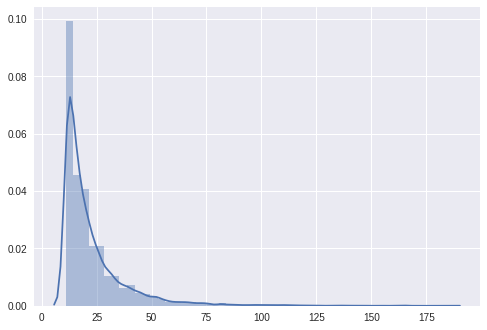

In [14]:
sns.distplot(user_count[user_count>10].values)

从上图可以看出单个用户所评论电影数多为1部，单个用户所评论电影数增加，对应的用户数量减少，能看多部top250电影且多部电影都去评论的人不多，有的人可能只看了那么几部，有的人可能看了没有评论。

### 不同类型用户评分情况

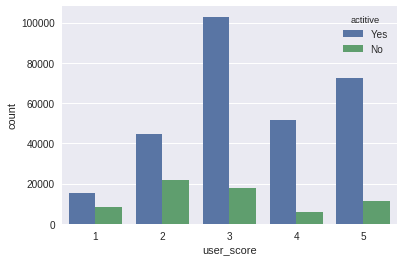

In [49]:
sns.countplot(x='user_score', hue='actitive', data=comments)

图中明显看出评论电影数大于一部的用户比较多，活跃用户好评数比差评数多，这些电影比较符合相对活跃的用户对于好电影的标准，而非活跃用户差评数比好评数多，可能是这些电影不太符合他们的对于好电影的标准，有可能这部分人看过一部觉得不怎么样之后就不想看其它top250的电影了，就只有一部电影的评论

### 不同类型用户短评赞同人数分布

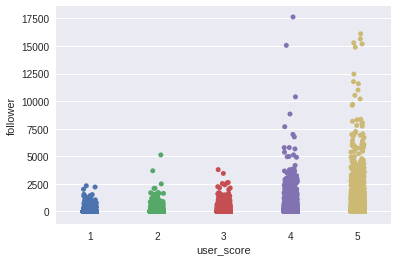

In [52]:
sns.stripplot(x='user_score', y='follower', data=comments[comments['actitive'] == 'Yes'], jitter=True)

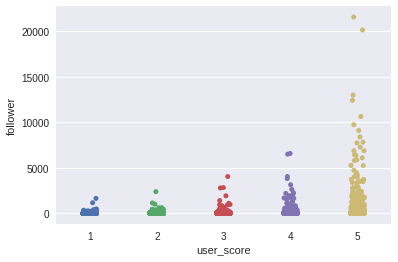

In [53]:
sns.stripplot(x='user_score', y='follower', data=comments[comments['actitive'] == 'No'], jitter=True)

上面两张图看到活跃用户每种用户评分赞同人数较非活跃用户多，可能是看过多部电影洞察力较非活跃用户好，评论能引起更多共鸣，也有可能是看过很多部电影的用户是比较活跃的用户，具有一定的粉丝量等。